Импортируем нужные библиотеки

In [283]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


# **Проведите предварительную обработку данных, включая обработку отсутствующих значений, кодирование категориальных признаков и масштабирование.**

In [284]:
data = pd.read_csv("WineDataset.csv")

In [285]:
#Проверка отсутствующих занчений
data.isna().sum()

Alcohol                         0
Malic Acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
Wine                            0
dtype: int64

array([[<Axes: title={'center': 'Alcohol'}>,
        <Axes: title={'center': 'Malic Acid'}>,
        <Axes: title={'center': 'Ash'}>,
        <Axes: title={'center': 'Alcalinity of ash'}>],
       [<Axes: title={'center': 'Magnesium'}>,
        <Axes: title={'center': 'Total phenols'}>,
        <Axes: title={'center': 'Flavanoids'}>,
        <Axes: title={'center': 'Nonflavanoid phenols'}>],
       [<Axes: title={'center': 'Proanthocyanins'}>,
        <Axes: title={'center': 'Color intensity'}>,
        <Axes: title={'center': 'Hue'}>,
        <Axes: title={'center': 'OD280/OD315 of diluted wines'}>],
       [<Axes: title={'center': 'Proline'}>,
        <Axes: title={'center': 'Wine'}>, <Axes: >, <Axes: >]],
      dtype=object)

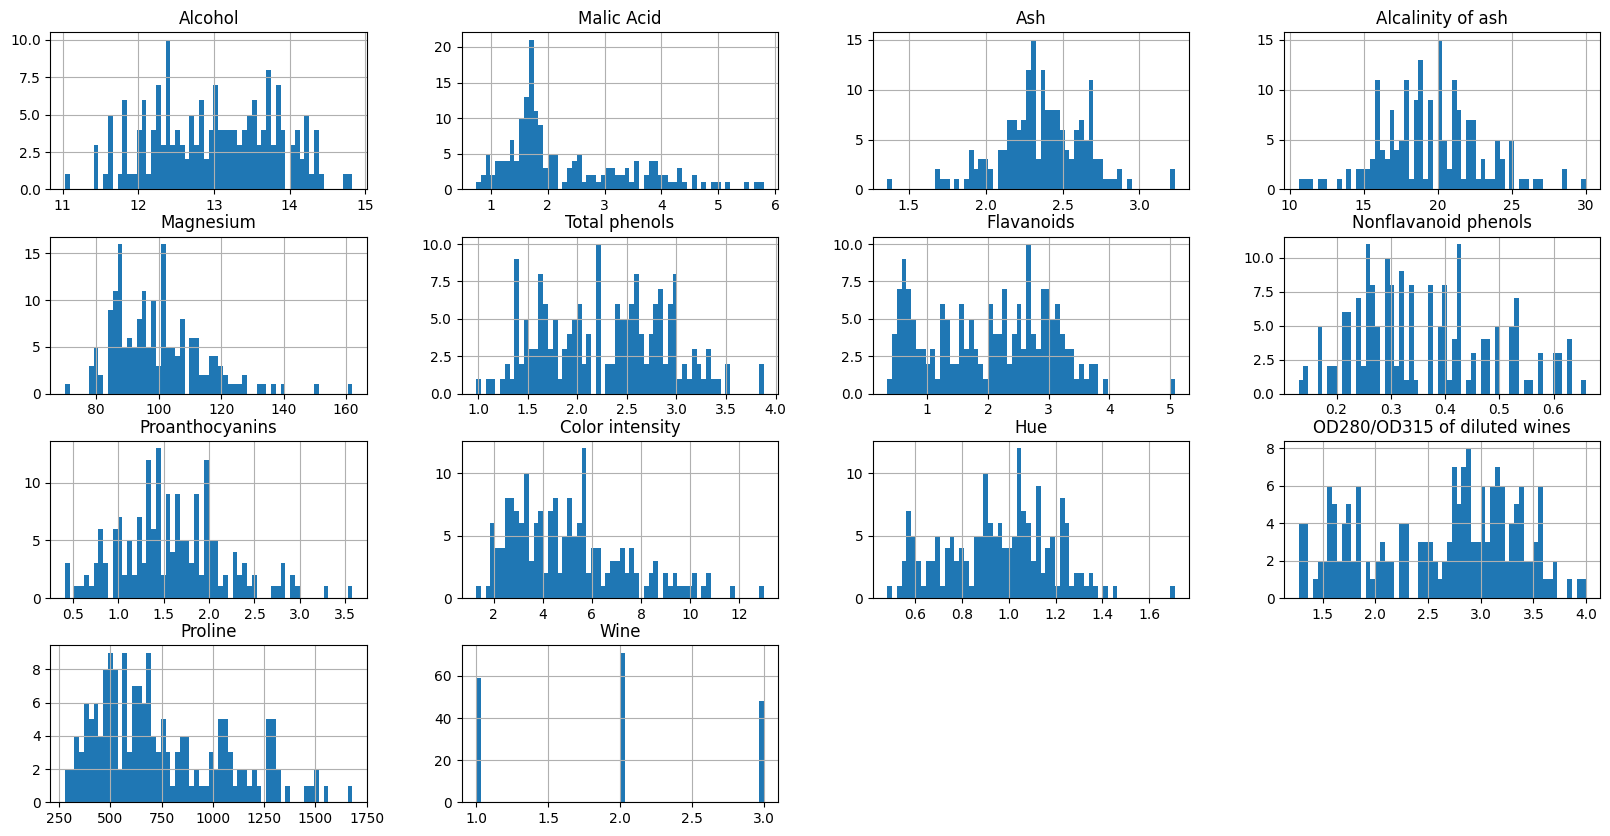

In [286]:
#Посмотрим на данные
data.hist(bins=60, figsize=(20, 10))


In [287]:
X = data.drop(columns=['Wine'])
y = data['Wine']

In [288]:
# Масштабирование
def MinMaxScaler(A):
    for i in A.columns:
        maxi = A[i].max()
        mini = A[i].min()
        A[i] = (A[i] - mini) / (maxi - mini)
    return A

# Разделение на обучающий и тестовый наборы
def train_test_split_custom(X, y, test_size=0.2):
    num_samples = X.shape[0]
    num_test_samples = int(test_size * num_samples)

    # Генерация случайных индексов для тестового набора
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)

    # Индексы для обучающего набора
    train_indices = np.setdiff1d(np.arange(num_samples), test_indices)

    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    return X_train, X_test, y_train, y_test

In [289]:
X = MinMaxScaler(X)
X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.2)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# **Реализуйте метод k-ближайших соседей без использования сторонних библиотек, кроме NumPy и Pandas.**

In [290]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Евклидово расстояние
    def distance(self, x0, x1):
        return np.sqrt(np.sum((x0 - x1)**2))

    # Наиболее частый класс
    def most_common(self, y):
        labels = np.unique(y)
        count = [list(y).count(i) for i in labels]
        return labels[np.argmax(count)]

    def predict(self, X_test):
        # Предсказываем метки классов
        labels = [self.find_labels(x) for x in X_test]
        return np.array(labels)

    def find_labels(self, x):
        # Считаем расстояние
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        # Берем индексы наблюдений
        k_nearest = np.argsort(distances)[:self.k]
        # По индексам берем метки классов
        labels = [self.y_train[i] for i in k_nearest]
        return self.most_common(labels)

In [291]:
def f1_score(y_test, pred):
      # Classes = [TP, FP, TN, FN]
      y_test = y_test.flatten()
      TP = 0
      FP = 0
      TN = 0
      FN = 0

      classes = list(set(y_test.tolist()))
      classes_stats = [[0, 0, 0, 0]] * len(classes)
      for i, cur_class in enumerate(classes):
        for idx, (el1, el2) in enumerate(zip(y_test, pred)):
            if (el1 == el2 == cur_class):
                TP += 1
                classes_stats[i][0] += 1
            if (el2 == cur_class and el1 != el2):
                FP += 1
                classes_stats[i][1] += 1
            if (el1 == el2 and el1 != cur_class):
                classes_stats[i][2] += 1
                TN += 1
            if (el1 != el2 and el1 != cur_class):
                classes_stats[i][3] += 1
                FN += 1

      return TP / (TP + (1 / (len(classes))) * (FP + FN))

In [292]:
def confusion_matrix(y_test, pred):
	#Classes = [TP, FP, TN, FN]
	y_test = y_test.flatten()
	TP = 0
	FP = 0
	TN = 0
	FN = 0

	classes = list(set(y_test.tolist()))
	num_classes = len(classes)
	confusion_matrix = np.zeros((num_classes, num_classes))
	for true_label, predicted_label in zip(y_test, pred):
		true_label_index = classes.index(true_label)
		predicted_label_index = classes.index(predicted_label)
		confusion_matrix[true_label_index][predicted_label_index] += 1

	return confusion_matrix

In [293]:
import seaborn as sns

def show_cf_matrix(cf_matrix):
  fig, AX = plt.subplots(figsize=(3, 2))
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Purples')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  ax.xaxis.set_ticklabels(['1','2','3'])
  ax.yaxis.set_ticklabels(['1','2','3'])

  plt.show()

# - **Постройте две модели k-NN с различными наборами признаков:**
    - Модель 1: Признаки случайно отбираются .
    - Модель 2: Фиксированный набор признаков, который выбирается заранее.

['Proline', 'Nonflavanoid phenols', 'Total phenols', 'Hue', 'Proanthocyanins', 'Alcalinity of ash', 'Malic Acid', 'OD280/OD315 of diluted wines', 'Flavanoids', 'Alcohol', 'Ash']


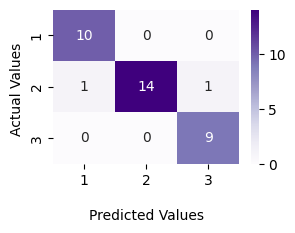

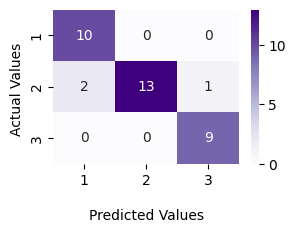

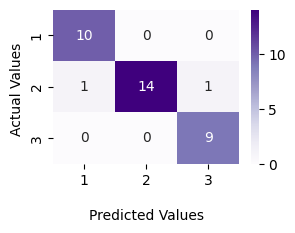

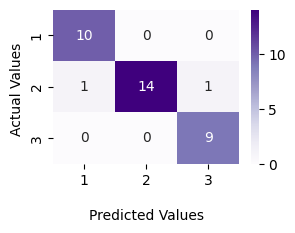

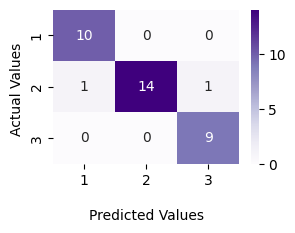

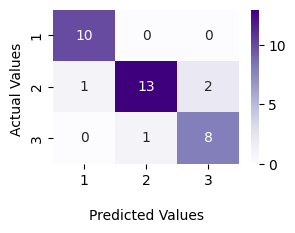

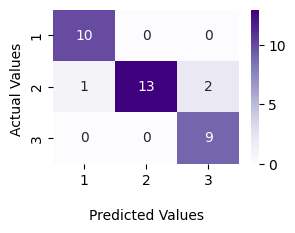

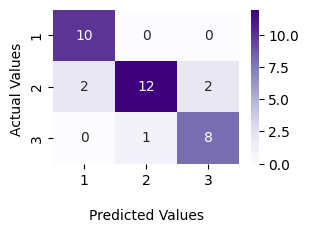

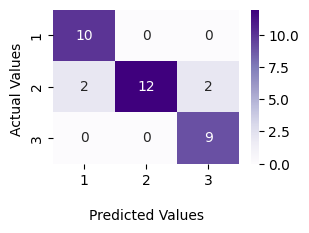

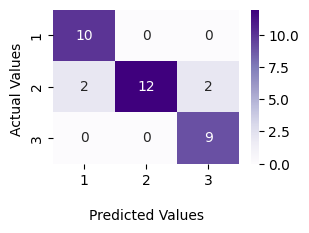

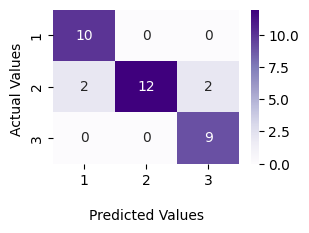

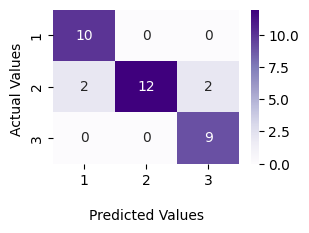

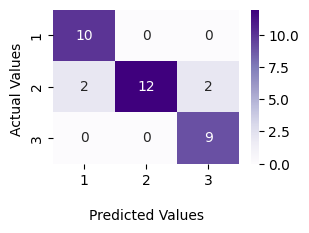

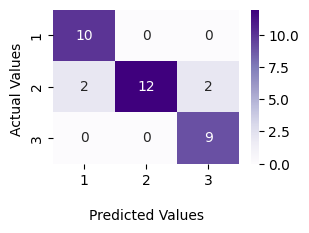

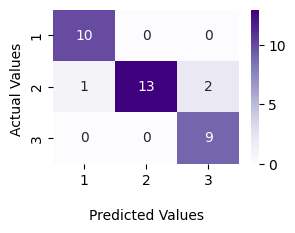

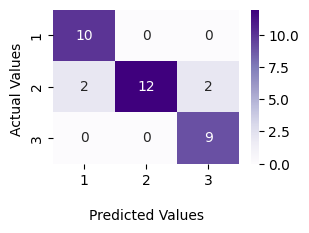

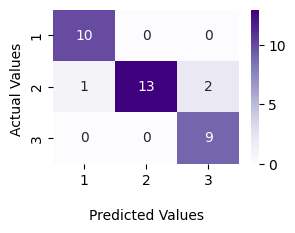

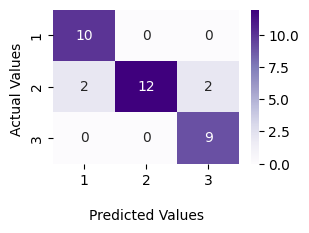

<function matplotlib.pyplot.show(close=None, block=None)>

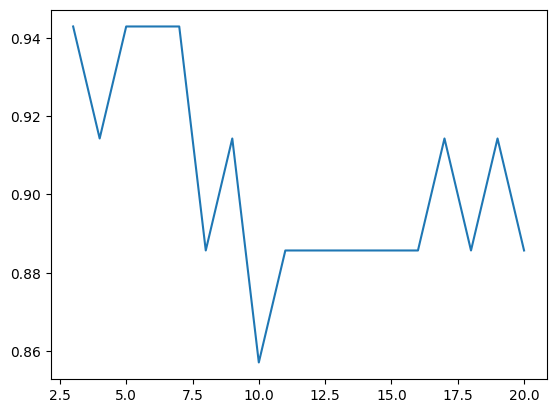

In [294]:
# Модель со случайными признаками
tags = ["Alcohol", "Malic Acid","Ash","Alcalinity of ash","Magnesium","Total phenols","Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280/OD315 of diluted wines","Proline"]
n = random.randint(1,13)
tags_1 = random.sample(tags, n)
print(tags_1)

X_test_rand = X_test[tags_1]
X_train_rand = X_train[tags_1]
X_test_rand=X_test_rand.to_numpy()
X_train_rand = X_train_rand.to_numpy()
k=[]
test_score = []
for i in range(3,21,1):
  clf = KNN(k=i)
  clf.fit(X_train_rand,y_train_np)
  y_pred = clf.predict(X_test_rand)
  show_cf_matrix(confusion_matrix(y_test_np, y_pred))
  test_score.append(f1_score(y_test_np,y_pred))
  k.append(i)

plt.plot(k,test_score)
plt.show

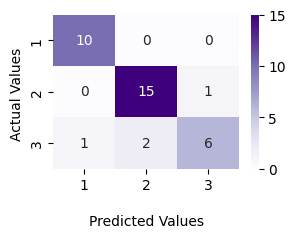

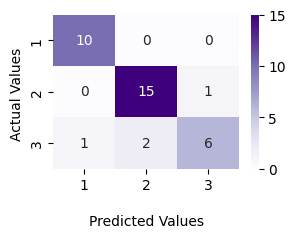

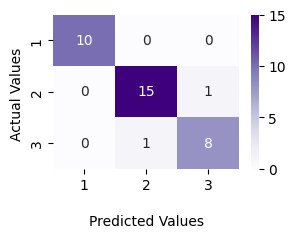

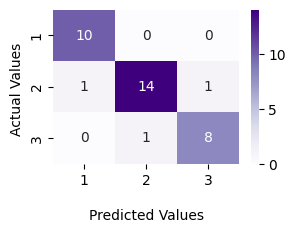

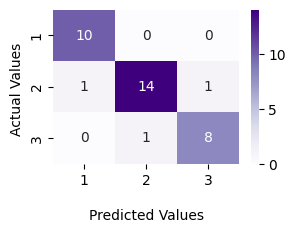

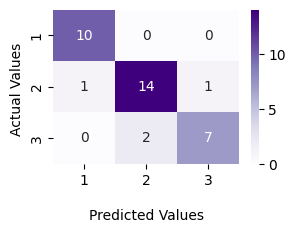

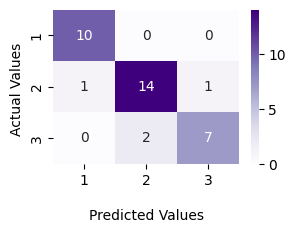

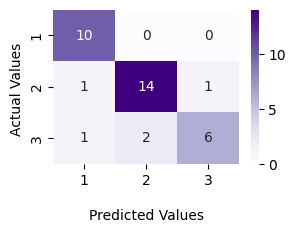

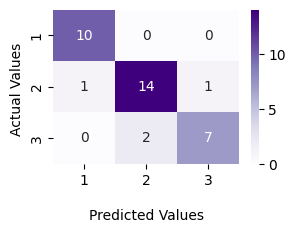

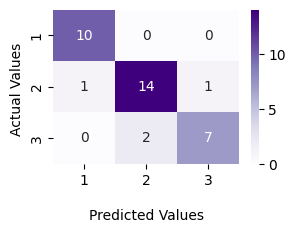

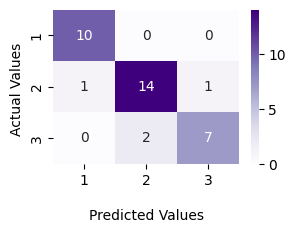

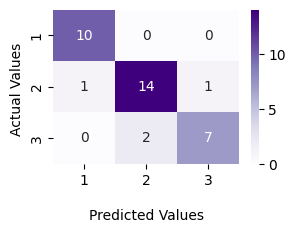

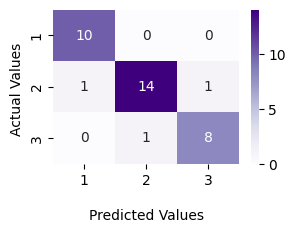

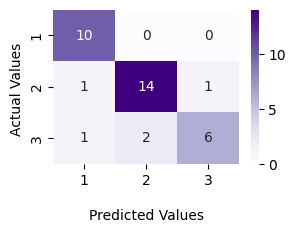

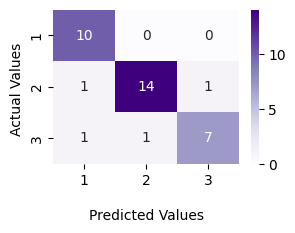

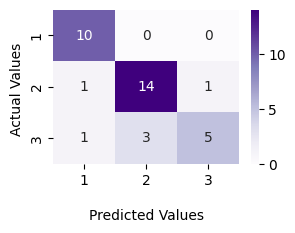

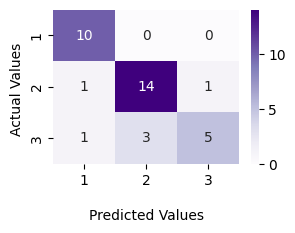

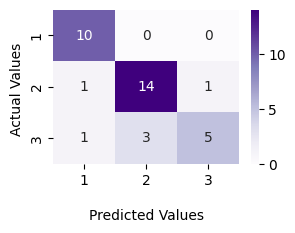

<function matplotlib.pyplot.show(close=None, block=None)>

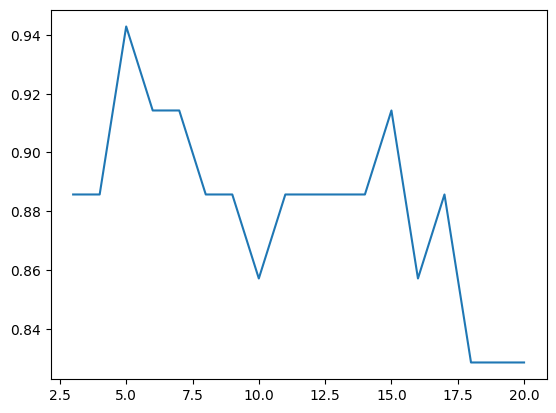

In [295]:
# Модель с фиксированными признаками
k=[]
test_score = []
tags = ["Total phenols","Alcohol","Color intensity"]
X_test_fix = X_test[tags]
X_train_fix = X_train[tags]
X_test_fix=X_test_fix.to_numpy()
X_train_fix = X_train_fix.to_numpy()
k=[]
test_score = []
for i in range(3,21,1):
  clf = KNN(k=i)
  clf.fit(X_train_fix,y_train_np)
  y_pred = clf.predict(X_test_fix)
  show_cf_matrix(confusion_matrix(y_test_np, y_pred))
  test_score.append(f1_score(y_test_np,y_pred))
  k.append(i)

plt.plot(k,test_score)
plt.show


# **ВЫВОД**
Можно заметить, что с увеличением количества ближайших соседей показатель f1_score падает. Оптимальным количеством соседей является 5-7 для данного набора тренировочных и тестовых данных.